#Introduction

##Project Motivation & Aim

As the number of products lining store shelves increases, the act of manually sorting items based on their type and brand can grow extremely tedious and time-consuming.

We hope to make this process easier by creating an algorithm that is able to classify products by type and brand. The output of this algorithm would then be able to be used by sorting machines to achieve automation.


##Description of Proposed Solution

We have developed several networks using two different machine learning models, Multilayer Perceptrons (MLP) and Convolutional Neural Network (CNN), which are able to identify a product's brand and type when given an image of the product. Thus automating the classification of these items.

#Setting Up

In [ ]:
# Mount Google Drive for Google Colab
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_Project'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/CS4243_Project
/content/gdrive/My Drive/CS4243_Project


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import urllib

from PIL import Image
from random import randint
from skimage.transform import resize
from torchvision import transforms

##WebScraper

We gathered all images used during our training and testing through Google image search. To expedite this tedious process, we developed a webscraper using Selenium that is able to download the search results from a Google image search given a specific query.

The design of this webscraper was inspired by guides from [Chris Zaire](https://levelup.gitconnected.com/how-to-download-google-images-using-python-2021-82e69c637d59), [korakot](https://gist.github.com/korakot/5c8e21a5af63966d80a676af0ce15067), and [Python Tutorials](https://pythonspot.com/selenium-get-images/).
(idk if we need to include this line)

In [ ]:
# Install chromium, its driver, and selenium
!apt update
!apt install chromium-chromedriver
!pip install selenium
# Set options to be headless, ..
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')

In [ ]:
# Open Google search images with specified search
driver = webdriver.Chrome(options=options)

search = 'A%26W+root+beer+can'
filename = 'AnW'

url = 'https://www.google.ca/search?q='+search+'&tbm=isch&oq='+search
driver.get(url)

# Scroll through the page to load everything in
last_height = driver.execute_script('return document.body.scrollHeight')
while True:
    driver.execute_script('window.scrollTo(0,document.body.scrollHeight)')
    time.sleep(2)
    new_height = driver.execute_script('return document.body.scrollHeight')
    try:
        driver.find_element(by=By.XPATH, value='//*[@id="islmp"]/div/div/div/div/div[5]/input').click()
        time.sleep(2)
    except:
        pass
    if new_height == last_height:
        break
    last_height = new_height

# Download images
# Note: remember to first manually create the folder in your drive
download_location = '/content/gdrive/MyDrive/CS4243_Project/img/' + filename + "/"

imgNum = 500
downloaded = 0

for i in range(1, imgNum):
    try:
        img = driver.find_element(by=By.XPATH, value='//*[@id="islrg"]/div[1]/div['+str(i)+']/a[1]/div[1]/img')
        src = img.get_attribute('src')
        urllib.request.urlretrieve(src, download_location + filename + "(" + str(i) + ").jpg")
        downloaded += 1
    except:
        continue

print("Number of downloaded images:", downloaded)

This process can be repeated as many times as desired. Here, we searched for 10 products from different brands and labelled them as follows:

In [ ]:
# Dictionary of labels

brands = {
  "Oreos" : 0,
  "Lotus" : 1,
  "HelloPanda" : 2,
  "Pringles" : 3,
  "Lays" : 4,
  "CheezIt" : 5,
  "Coke" : 6,
  "Pepsi" : 7,
  "Sprite" : 8,
  "AnW" : 9,
}

types = {
  "Oreos" : 0,
  "Lotus" : 0,
  "HelloPanda" : 0,
  "Pringles" : 1,
  "Lays" : 1,
  "CheezIt" : 1,
  "Coke" : 2,
  "Pepsi" : 2,
  "Sprite" : 2,
  "AnW" : 2,
}

After collecting all our images, we then converted these images into PyTorch tensors so our neural networks can work with them.

When converting images into tensors, we first resized every image to 32 x 32 pixels. We also included 4 rotations of each image to increase the size of our data set and improve the generalisation of our final neural networks.

Note: Remove unwanted images from folder before proceeding. During this process, we removed all images that did not include our target product, even if it included a different product from the same brand (e.g. we collected images of Lotus Biscoff Biscuits, and deleted images that only contained Lotus Biscoff Creamy Cookie Butter Spread)

In [ ]:
# Redefining these two variables here for convenience. 
# Change `filename` to indicate which images are to be converted. 
filename = filename
download_location = '/content/gdrive/MyDrive/CS4243_Project/img/' + filename + "/"

img_tensors = []
convert_tensor = transforms.ToTensor()

# Standardise size for all images
for i in range(1, imgNum):
    try:
        img = Image.open(download_location + filename + "(" + str(i) + ").jpg")
    except:
        continue

    img = img.resize((32, 32))

    # Add different rotations
    for angle in range (0, 360, 90):
        rotated = img.rotate(angle)

        # Convert file from jpg to tensor
        x = convert_tensor(rotated)

        # Add tensor to list
        img_tensors.append(x)

data_location = '/content/gdrive/MyDrive/CS4243_Project/data/' + filename + 'Tensor/'

# Create the same number of brand labels and type labels
label_arr = [brands[filename]] * len(img_tensors)
label_tensors = torch.as_tensor(label_arr)

type_arr = [types[filename]] * len(img_tensors)
type_tensors = torch.as_tensor(type_arr)

# Save tensors to file only after all jpgs have been converted
torch.save(img_tensors, data_location + filename + 'Tensor.pt')
torch.save(label_tensors, data_location + filename + 'Labels.pt')
torch.save(type_tensors, data_location + filename + 'TypeLabels.pt')

print("Number of tensors created:", len(img_tensors))
print("Size of 1 tensor:", img_tensors[0].size() )

To make organisation easier, tensors for each group of images were initially stored in separate files. Here, we merge all tensors into a single file for use during training and testing.

In [ ]:
# Merge all tensors
names = brands.keys()
data_tensors = []
brand_labels = []
type_labels = []
for filename in names:
  data_location = '/content/gdrive/MyDrive/CS4243_Project/data/' + filename + 'Tensor/'
  data = torch.load(data_location + filename + 'Tensor.pt')
  brand = torch.load(data_location + filename + 'Labels.pt')
  typelab = torch.load(data_location + filename + 'TypeLabels.pt')

  data_tensors += data
  brand_labels += brand
  type_labels += typelab

torch.save(data_tensors, '/content/gdrive/MyDrive/CS4243_Project/data/dataTensors.pt')
torch.save(brand_labels, '/content/gdrive/MyDrive/CS4243_Project/data/brandLabels.pt')
torch.save(type_labels, '/content/gdrive/MyDrive/CS4243_Project/data/typeLabels.pt')

print("Total number of tensors:", len(data_tensors))

During training, we noticed some tensors were in gray-scale, so we retroactively filtered them out.


In [ ]:
# Filter out gray-scale images
# Do not run multiple times

data = torch.load('/content/gdrive/MyDrive/CS4243_Project/data/dataTensors.pt')
brands = torch.load('/content/gdrive/MyDrive/CS4243_Project/data/brandLabels.pt')
types = torch.load('/content/gdrive/MyDrive/CS4243_Project/data/typeLabels.pt')

filtered_data = []
filtered_brands = []
filtered_types = []

for i in range(0, 4800):
    if (data[i].size(0) == 3):
        filtered_data.append(data[i])
        filtered_brands.append(brands[i])
        filtered_types.append(types[i])

# Save to a different file for insurance, remove the "Cleaned" part after
torch.save(filtered_data, '/content/gdrive/MyDrive/CS4243_Project/data/dataTensorsCleaned.pt')
torch.save(filtered_brands, '/content/gdrive/MyDrive/CS4243_Project/data/brandLabelsCleaned.pt')
torch.save(filtered_types, '/content/gdrive/MyDrive/CS4243_Project/data/typeLabelsCleaned.pt')

print("Final total number of usable tensors:", len(filtered_data))

The amount of pictures collected across brands and product types are shown in the graph below.

<div>
<img
src = "https://drive.google.com/uc?id=19IfSn5lbgTzO9iH34UEaeF-vsMMpRj4c"
width = "500"/>
</div>

##Initial Hypothesis

After retrieving our data set, our team hypothesised that the CNNs would produce better results than the MLP models.

Although we tried to clean our data as best as we could, the difference in lighting, position and size of the product, quality of the image etc. all put the MLP models at a disadvantage.

#Training & Testing

Before sending them off to our neural networks, we separated our data set into a training data set and a testing data set, with a ratio of 7:3.

In [ ]:
# Load in the intial data sets
total_data = torch.load("data/dataTensors.pt")
type_labels = torch.load("data/typeLabels.pt")
brand_labels = torch.load("data/brandLabels.pt")

# Check the size of each dataset and the individual tensors
num_total_data = len(total_data)
tensor_size = total_data[0].size()
type_label_size = len(type_labels)
brand_label_size = len(brand_labels)
print(f"There are {num_total_data} images, each of them is of size {tensor_size}.")
print(f"There are {type_label_size} and {brand_label_size} labels for product types and brand respectively.")

There are 4740 images, each of them is of size torch.Size([3, 32, 32]).
There are 4740 and 4740 labels for product types and brand respectively.


In [ ]:
# Adjust proportion of data used for training and testing
train_num = 0.7
test_num = 1 - train_num
print(f"{train_num * 100}% of total data is used for training, {test_num * 100}% is used for testing.")

num_train_data = int(train_num * num_total_data)
num_test_data = num_total_data - num_train_data

# Shuffle data
data_and_labels = list(zip(total_data, brand_labels, type_labels))
random.shuffle(data_and_labels)
shuffled_data, shuffled_brand_labels, shuffled_type_labels = zip(*data_and_labels)

# Split data
train_data = torch.stack(shuffled_data[0:num_train_data])
test_data = torch.stack(shuffled_data[num_train_data:])

# Labels for brand
train_brand_labels = torch.stack(shuffled_brand_labels[0:num_train_data])
test_brand_labels = torch.stack(shuffled_brand_labels[num_train_data:])

#Labels for product type
train_type_labels = torch.stack(shuffled_type_labels[0:num_train_data])
test_type_labels = torch.stack(shuffled_type_labels[num_train_data:])

print(f"{num_train_data} training data, {num_test_data} test data")

70.0% of total data is used for training, 30.000000000000004% is used for testing.
3318 training data, 1422 test data


In [ ]:
# Used to normalise data set for CNN training
mean = train_data.mean()
print("The mean of the training set is:", mean)

std = train_data.std()
print("The standard deviation of the training set is:", std)

The mean of the training set is: tensor(0.6255)
The standard deviation of the training set is: tensor(0.3244)


To check for the accuracy of our neural networks, we created two helper functions to evaluate over the test set.

In [ ]:
def eval_on_MLP_test_set(net, labels):

    running_error = 0
    num_batches = 0

    for i in range(0, num_test_data, bs):

        minibatch_data = test_data[i:i+bs]
        minibatch_label = labels[i:i+bs]

        inputs = minibatch_data.view(-1,3072)

        scores = net(inputs)

        error = get_error(scores , minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches

    print('test error=', total_error*100 ,'percent')

In [ ]:
def eval_on_CNN_test_set(net, labels):

    running_error = 0
    num_batches = 0

    for i in range(0, num_test_data, bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label = labels[i:i+bs]

        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        # Normalize input for CNN
        inputs = (minibatch_data - mean)/std

        scores = net(inputs) 

        error = get_error(scores , minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches

    print('test error=', total_error*100, 'percent')

##3-Layer MLP

We created a simple, 3-layer MLP network, leaving the size of the hidden layers to be accepted as input parameters to make it easier to change the hyper-parameters during testing.

In [ ]:
class three_layer_net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(three_layer_net, self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1)
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2)
        self.layer3 = nn.Linear(  hidden_size2 , output_size )

    def forward(self, x):
      
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)

        return scores

In [ ]:
input_size = 32*32*3

# Hyper-parameters can be adjusted
hidden_size1 = 50 
hidden_size2 = 32

brand_output_size = 10
type_output_size = 3

###Brand classification

In [ ]:
brand_MLP_net = three_layer_net(input_size, hidden_size1, hidden_size2, brand_output_size)
print(brand_MLP_net)

three_layer_net(
  (layer1): Linear(in_features=3072, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
brand_MLP_lr = 0.01

brand_MLP_criterion = nn.CrossEntropyLoss()

brand_MLP_optimizer = torch.optim.SGD(brand_MLP_net.parameters() , brand_MLP_lr)

bs = 50

During training, we ran a total of 50 epochs to give each neural network ample time to train.

We also tested the accuracy of the network on the test set after each epoch to keep track of how the neural network is improving overall, rather than just memorising the training set.

In [ ]:
start = time.time()

for epoch in range(50):
    
    running_loss = 0
    running_error = 0
    num_batches = 0
    
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, bs):
        
        # forward and backward pass
    
        brand_MLP_optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
            
        minibatch_data = train_data[indices]
        minibatch_labels = train_brand_labels[indices] # difference between brand & type training

        inputs = minibatch_data.view(-1,3072) # bs * 3 * 32 * 32 -> bs * 3072

        inputs.requires_grad_()

        scores = brand_MLP_net(inputs) #CHANGE THE NET

        loss = brand_MLP_criterion(scores, minibatch_labels) 
        
        loss.backward()

        brand_MLP_optimizer.step()
        
        
        # Compute some stats
        
        running_loss += loss.detach().item()
               
        # Run `Appendix: utils.py` cell at the bottom of this note book if this causes an error
        error = get_error(scores.detach(), minibatch_labels)
        running_error += error.item()
        
        num_batches += 1
    
    
    # Once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=', epoch, '\t time=', elapsed, 'min', '\t lr=', brand_MLP_lr, '\t loss=', total_loss, '\t error=', total_error*100, 'percent')
        
    eval_on_MLP_test_set(brand_MLP_net, test_brand_labels) # difference between brand & type testing
    print(' ')

epoch= 0 	 time= 0.0029793302218119305 min 	 lr= 0.01 	 loss= 2.285945721526644 	 error= 85.44278651920717 percent
test error= 83.25391884507805 percent
 
epoch= 1 	 time= 0.006263593832651774 min 	 lr= 0.01 	 loss= 2.2487383209057707 	 error= 78.86235518241996 percent
test error= 86.31975013634255 percent
 
epoch= 2 	 time= 0.009567642211914062 min 	 lr= 0.01 	 loss= 2.1886082727517655 	 error= 74.61691534341271 percent
test error= 73.69905956860246 percent
 
epoch= 3 	 time= 0.012803932030995687 min 	 lr= 0.01 	 loss= 2.081418265157671 	 error= 70.05638471290247 percent
test error= 67.61128594135415 percent
 
epoch= 4 	 time= 0.01613377332687378 min 	 lr= 0.01 	 loss= 1.9367064504481073 	 error= 66.76948666572571 percent
test error= 64.43887209070141 percent
 
epoch= 5 	 time= 0.019588724772135416 min 	 lr= 0.01 	 loss= 1.806749648122645 	 error= 63.197346587679284 percent
test error= 70.4576796498792 percent
 
epoch= 6 	 time= 0.02294268210728963 min 	 lr= 0.01 	 loss= 1.71390774712

After all the training is finished, we can choose a random picture from our test set and see how well our neural network does at identifying the image.

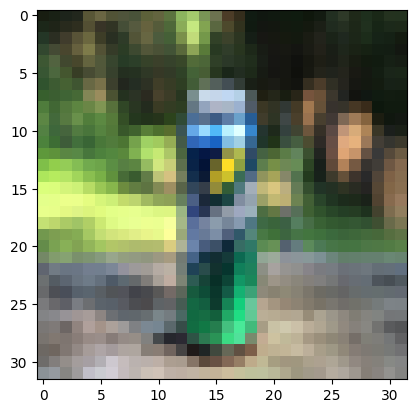

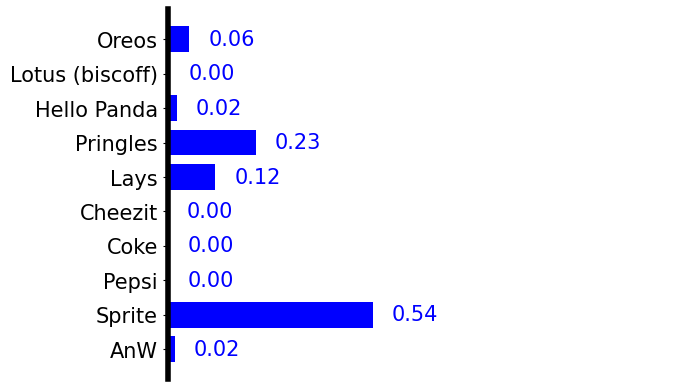

In [ ]:
# Choose a picture at random
idx = randint(0, num_test_data-1)
im = test_data[idx]

# Diplay the picture
show(im)

# Feed it to the net and display the confidence scores
scores = brand_MLP_net(im.view(-1,3072)) 
probs = torch.softmax(scores, dim=1)
show_prob_brand(probs)

###Type classification

For type classification, we initialised the same three_layer_net as we did with brand classification, with the key difference being the output size, which has been decreased from 10 brands to 3 product types.

In [ ]:
type_MLP_net = three_layer_net(input_size, hidden_size1, hidden_size2, type_output_size)
print(type_MLP_net)

three_layer_net(
  (layer1): Linear(in_features=3072, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
type_MLP_lr = 0.01

type_MLP_criterion = nn.CrossEntropyLoss()

type_MLP_optimizer = torch.optim.SGD( type_MLP_net.parameters() , type_MLP_lr )

bs = 50

50 epoch training loop.

In [ ]:
start = time.time()

for epoch in range(50):
    
    running_loss = 0
    running_error = 0
    num_batches = 0
    
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, bs):
        
        # forward and backward pass
    
        type_MLP_optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
            
        minibatch_data = train_data[indices]
        minibatch_labels= train_type_labels[indices] # difference between brand & type training

        inputs = minibatch_data.view(-1,3072) # bs * 3 * 32 * 32 -> bs * 3072

        inputs.requires_grad_()

        scores = type_MLP_net(inputs) #CHANGE THE NET

        loss = type_MLP_criterion(scores , minibatch_labels) 
        
        loss.backward()

        type_MLP_optimizer.step()
        
        
        # Compute some stats
        
        running_loss += loss.detach().item()
               
        # Run `Appendix: utils.py` cell at the bottom of this note book if this causes an error
        error = get_error(scores.detach() , minibatch_labels)
        running_error += error.item()
        
        num_batches+=1
    
    
    # Once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=', epoch, '\t time=', elapsed, 'min', '\t lr=', type_MLP_lr, '\t loss=', total_loss, '\t error=', total_error*100, 'percent')
        
    eval_on_MLP_test_set(type_MLP_net, test_type_labels) # difference between brand & type testing
    print(' ')

epoch= 0 	 time= 0.0028397758801778157 min 	 lr= 0.01 	 loss= 1.0643767002803177 	 error= 53.98341595236935 percent
test error= 46.583071864884474 percent
 
epoch= 1 	 time= 0.006077682971954346 min 	 lr= 0.01 	 loss= 1.0044006981066804 	 error= 48.252072530006295 percent
test error= 49.39811825752258 percent
 
epoch= 2 	 time= 0.0096635103225708 min 	 lr= 0.01 	 loss= 0.965333340772942 	 error= 47.422884738267356 percent
test error= 47.517241486187636 percent
 
epoch= 3 	 time= 0.012949470678965251 min 	 lr= 0.01 	 loss= 0.9474300653187196 	 error= 47.32006574744609 percent
test error= 48.06896530348679 percent
 
epoch= 4 	 time= 0.01615639527638753 min 	 lr= 0.01 	 loss= 0.9378752939736665 	 error= 47.85737964644361 percent
test error= 47.24137926923817 percent
 
epoch= 5 	 time= 0.019393853346506753 min 	 lr= 0.01 	 loss= 0.9258643886936244 	 error= 46.862354741167664 percent
test error= 47.172413201167664 percent
 
epoch= 6 	 time= 0.022644976774851482 min 	 lr= 0.01 	 loss= 0.9203

Testing on a random image from the test set.

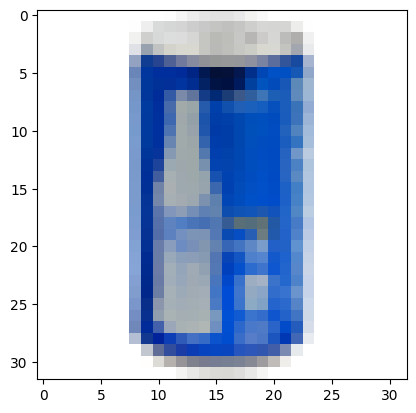

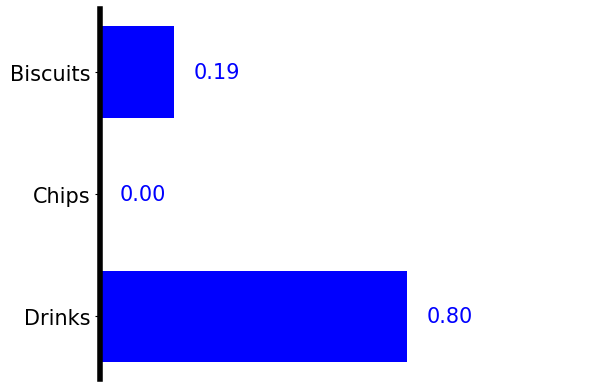

In [ ]:
# choose a picture at random
idx = randint(0, num_test_data-1)
im = test_data[idx]

# diplay the picture
show(im)

# feed it to the net and display the confidence scores
scores = type_MLP_net(im.view(-1,3072)) 
probs = torch.softmax(scores, dim=1)
show_prob_type(probs)

##CNN

For our CNNs, we created a network with 4 convolutional layers and 3 linear layers, an architecture similar to the VGG architecture that was discussed during lecture.

We decided to hardcode all hyper-parameters into the CNN class as taking all hyper-parameters as input would result in long, clumsy code during initialisation. However, we still take in the final output_size as an input parameter so we can reuse this class for any number of results.

In [ ]:
class CNN(nn.Module):

    def __init__(self, output_size):

        super(CNN, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, output_size)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

CNNs, especially with our architecture, are quite computationally heavy, so we decided to make use of Google Collab's GPU, "cuda".

In [ ]:
device = torch.device("cuda")
print(device)

cuda


###Brand classification

In [ ]:
brand_CNN_net = CNN(output_size=10)

print(brand_CNN_net)

CNN(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_featur

In [ ]:
# Send parameters to GPU
brand_CNN_net = brand_CNN_net.to(device)

mean = mean.to(device)

std = std.to(device)

In [ ]:
brand_CNN_criterion = nn.CrossEntropyLoss()
brand_CNN_lr = 0.25 
bs = 50

Similar to the MLP's training, we ran the training loop for 50 epochs.

In [ ]:
start = time.time()

for epoch in range(50):
    
    # Divide the learning rate by 2 every 5 epochs
    if epoch % 5 == 0:
        brand_CNN_lr = brand_CNN_lr / 2
    
    # Create a new optimizer at the beginning of each epoch; give the current learning rate.   
    brand_CNN_optimizer = torch.optim.SGD(brand_CNN_net.parameters() , lr=brand_CNN_lr )
        
    # Set the running quatities to zero at the beginning of the epoch
    running_brand_loss = 0
    running_brand_error = 0
    num_batches = 0
    
    # Set the order in which to visit the image from the training set
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, bs):
    
        # Set the gradients to zeros
        brand_CNN_optimizer.zero_grad()
        
        # Create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_brand_labels = train_brand_labels[indices] # difference between brand & type training
        
        # Send them to the gpu
        minibatch_data = minibatch_data.to(device)
        minibatch_brand_labels = minibatch_brand_labels.to(device)
        
        # Normalize the minibatch
        inputs = (minibatch_data - mean)/std
        
        # Tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # Forward the minibatch through the net 
        scores = brand_CNN_net(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        brand_loss = brand_CNN_criterion(scores, minibatch_brand_labels) 
        
        # Backward pass to compute dL/dU, dL/dV and dL/dW
        brand_loss.backward()

        # Do one step of the optimizer
        brand_CNN_optimizer.step()
        

        # START COMPUTING STATS
        
        # Add the loss of this batch to the running loss
        running_brand_loss += brand_loss.detach().item()
        
        # Compute the error made on this batch and add it to the running error
        # Run `Appendix: utils.py` cell at the bottom of this note book if this causes an error       
        brand_error = get_error(scores.detach(), minibatch_brand_labels)
        running_brand_error += brand_error.item()

        num_batches += 1        
    
    
    # compute stats for the full training set
    total_brand_loss = running_brand_loss/num_batches
    total_brand_error = running_brand_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=', epoch, '\t total time=', elapsed, 'min', '\t lr=', brand_CNN_lr, '\t loss=', total_brand_loss, '\t error=', total_brand_error*100, 'percent')

    eval_on_CNN_test_set(brand_CNN_net, test_brand_labels) 
    print(' ')

epoch= 0 	 total time= 0.06744328737258912 min 	 lr= 0.125 	 loss= 2.2974654240394705 	 error= 88.87230487012151 percent
test error= 89.04702211248463 percent
 
epoch= 1 	 total time= 0.1407300551732381 min 	 lr= 0.125 	 loss= 2.294171507678815 	 error= 88.58043133322873 percent
test error= 89.75548579775054 percent
 
epoch= 2 	 total time= 0.2100476384162903 min 	 lr= 0.125 	 loss= 2.2921530808975445 	 error= 87.68159177765918 percent
test error= 87.89341675824133 percent
 
epoch= 3 	 total time= 0.27968745231628417 min 	 lr= 0.125 	 loss= 2.1888972200564485 	 error= 83.34991745094756 percent
test error= 80.84012639933619 percent
 
epoch= 4 	 total time= 0.3514874855677287 min 	 lr= 0.125 	 loss= 2.00565052210395 	 error= 79.03482655980693 percent
test error= 78.63322948587353 percent
 
epoch= 5 	 total time= 0.42519085804621376 min 	 lr= 0.0625 	 loss= 1.7808920233996945 	 error= 74.42786195384923 percent
test error= 74.45768117904663 percent
 
epoch= 6 	 total time= 0.49493841330210

After training, we can again pick an image from the test set at random and see how well our neural network has done.

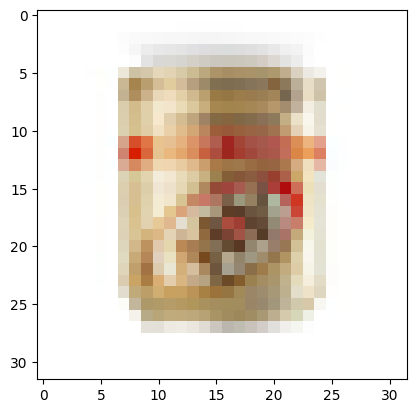

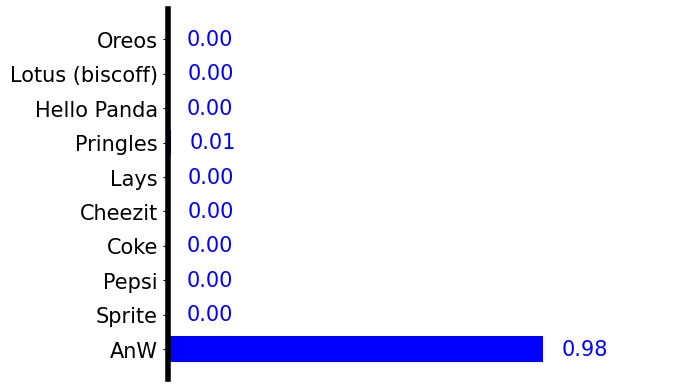

In [ ]:
# Choose a picture at random
idx = randint(0, num_test_data)
im = test_data[idx]

# diplay the picture
show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = (im-mean) / std
im = im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores = brand_CNN_net(im) 
probs = torch.softmax(scores, dim=1)
show_prob_brand(probs.cpu())

###Type classification

In [ ]:
type_CNN_net = CNN(output_size=3)

print(type_CNN_net)

CNN(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_featur

In [ ]:
# Send parameters to GPU
type_CNN_net = type_CNN_net.to(device)

mean = mean.to(device)

std = std.to(device)

In [ ]:
type_CNN_criterion = nn.CrossEntropyLoss()
type_CNN_lr = 0.5 
bs = 50

50 epoch training loop.

In [ ]:
start = time.time()

for epoch in range(50):
    
    # divide the learning rate by 2 every 5 epochs
    if epoch % 5 == 0:
        type_CNN_lr = type_CNN_lr / 2
    
    # create a new optimizer at the beginning of each epoch; give the current learning rate.   
    type_CNN_optimizer = torch.optim.SGD(type_CNN_net.parameters() , lr=type_CNN_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_type_loss = 0
    running_type_error = 0
    num_batches = 0
    
    # set the order in which to visit the image from the training set
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, bs):
    
        # Set the gradients to zeros
        type_CNN_optimizer.zero_grad()
        
        # Create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_type_labels = train_type_labels[indices] # difference between brand & type training
        
        # Send them to the gpu
        minibatch_data = minibatch_data.to(device)
        minibatch_type_labels = minibatch_type_labels.to(device)
        
        # Normalize the minibatch
        inputs = (minibatch_data - mean)/std
        
        # Tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # Forward the minibatch through the net 
        scores = type_CNN_net(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        type_loss = type_CNN_criterion(scores, minibatch_type_labels) 
        
        # Backward pass to compute dL/dU, dL/dV and dL/dW
        type_loss.backward()

        # Do one step of the optimizer
        type_CNN_optimizer.step()
        

        # START COMPUTING STATS
        
        # Add the loss of this batch to the running loss
        running_type_loss += type_loss.detach().item()
        
        # Compute the error made on this batch and add it to the running error       
        # Run `Appendix: utils.py` cell at the bottom of this note book if this causes an error
        type_error = get_error(scores.detach(), minibatch_type_labels)
        running_type_error += type_error.item()

        num_batches += 1        
    
    
    # compute stats for the full training set
    total_type_loss = running_type_loss/num_batches
    total_type_error = running_type_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=', epoch, '\t total time=', elapsed, 'min', '\t lr=', type_CNN_lr, '\t loss=', total_type_loss, '\t error=', total_type_error*100, 'percent')

    eval_on_CNN_test_set(type_CNN_net, test_type_labels) 
    print(' ')

epoch= 0 	 total time= 0.06577014525731405 min 	 lr= 0.25 	 loss= 1.056698815146489 	 error= 56.12935441643444 percent
test error= 57.811912585949074 percent
 
epoch= 1 	 total time= 0.13883476257324218 min 	 lr= 0.25 	 loss= 1.0166824397756093 	 error= 52.461029077643786 percent
test error= 52.08777538661299 percent
 
epoch= 2 	 total time= 0.20748507976531982 min 	 lr= 0.25 	 loss= 0.9644054868328038 	 error= 47.446104216931474 percent
test error= 49.8996874381756 percent
 
epoch= 3 	 total time= 0.2765070637067159 min 	 lr= 0.25 	 loss= 1.0213610191843403 	 error= 52.606966068495566 percent
test error= 52.91536142086161 percent
 
epoch= 4 	 total time= 0.34773167769114177 min 	 lr= 0.25 	 loss= 1.0265594783113963 	 error= 54.00000098925918 percent
test error= 70.94043822124087 percent
 
epoch= 5 	 total time= 0.42053696711858113 min 	 lr= 0.125 	 loss= 1.0862578456081562 	 error= 60.225539687854145 percent
test error= 57.811912585949074 percent
 
epoch= 6 	 total time= 0.48978538513

Testing on a random image from the test set.

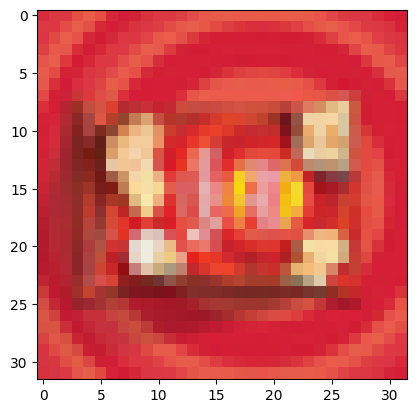

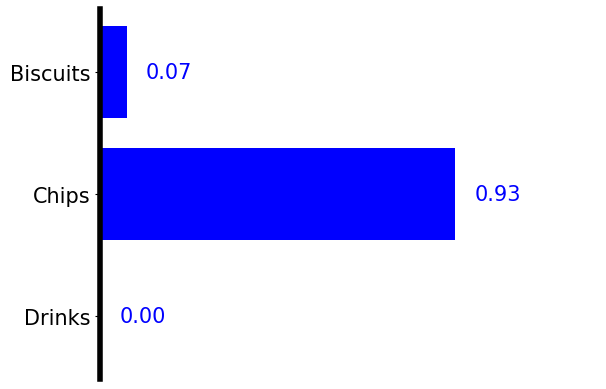

In [ ]:
# Choose a picture at random
idx = randint(0, num_test_data)
im = test_data[idx]

# diplay the picture
show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = (im-mean) / std
im = im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores = type_CNN_net(im) 
probs = torch.softmax(scores, dim=1)
show_prob_type(probs.cpu())

#Numerical Results

## Analysis

During our initial run through, we ran all training loops for both models with the same parameters: batch size = 50, epoch = 50, size of Training Set = 3318, size of Test Set = 1422.

To compare the CNN and MLP models for the two types of classification, Type of Products and Brand of Products, we took the error rates for each epoch of a sample run and visualized them in the following graphs.

###Brand classification

First, the error rate when classifying the Brand of Products using MLP and CNN:

<div>
<img src="https://drive.google.com/uc?id=18NIfGNqMa6fgQZ8D60YnWe2qdTi3vcwm" width="500"/>
</div>

<div>
<img src="https://drive.google.com/uc?id=1CqEfMQ81ehTRY5QeDKOigNcAIVzG1ioJ" width="500"/>
</div>

###Type classification

Second, the error rate when classifying the Type of Products using MLP and CNN:

<div>
<img src="https://drive.google.com/uc?id=1tveOE4YESlnWPv4GRIxzeg2WiXmanhNY" width="500"/>
</div>

<div>
<img src="https://drive.google.com/uc?id=1vggysIUB6NoVUEmQGpd-HhgOgIfmB8A6" width="500"/>
</div>

## Interpretation

With the exception of the type classifying MLP network, the error rates on the **training sets** for both models decreases at a relatively stable exponential pace. However, it is observed that for the MLP models, there are large fluctuations in error rate on the **test sets** as the number of epoch increases. The error rate on the **test sets** for the CNN model shows slight signs of fluctuations as well, but not to a large degree, decreasing at a similar rate as its training set.

In addition, even though the error rates on each set are initially similar, the CNN models achieved a more stable, lower error rate after 50 epochs, compared to the MLP models.

These trends were able to be replicated in subsequent runs of the training loop.




##Conclusion of Analysis

From both sets of visulisations, we can see that our initial hypothesis was correct. Although the complexity of the neural networks we created for each model could also be a factor, it is clear that the MLP networks struggled compared to the CNNs.

We believe this is largely due to the inconsistent placement and orientation of each product in the images, as previously mentioned.


Additionally, the Stochastic gradient descent (SGD) optimizers we used during our first training networks caused heavy fluctuations in the error rates of both sets during testing, which can be most obviously seen in the error rates for our MLP networks. However, this is a normal occurrence due to SGD’s [frequent updates with high variance](https://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent).

As the size of our data set is relatively small, and the frequencies of each feature of an object showing up is not uniform, SGD applying the same learning rate to all features caused our networks to reach an appropriate level of accuracy extremely slowly.

To combat this, we experimented with using the Adaptive Moment Estimation (Adam) optimizer instead, which uses adaptive learning rates for each parameter. In addition, it uses less memory which is much more efficient.


#Exploring Improvements

Initially, we used the same learning rate of 0.5 and a similar learning rate scheduler (i.e. dividing by 2 every 5 epochs), but we found during training that the error rates for both the training set and test set weren't improving.

After trying out a few different variations, we settled on using a static learning rate of 0.001, which yielded the best results.

###Brand classification

In [ ]:
brand_Adam_CNN_net = CNN(10)

brand_Adam_CNN_net = brand_Adam_CNN_net.to(device)

mean = mean.to(device)

std = std.to(device)

In [ ]:
brand_Adam_CNN_criterion = nn.CrossEntropyLoss()
brand_Adam_CNN_lr = 0.001 
bs = 50

Although we initially stuck with a 50 epoch training loop, we quickly realised that the Adam optimizer improved the network's training efficiency by such a large margin that it was no longer necessary. Thus, we shortened the training loop to only run for 10 epochs instead.

In [ ]:
start = time.time()

for epoch in range(15):
    
    # create a new optimizer at the beginning of each epoch; give the current learning rate.   
    brand_Adam_CNN_optimizer = torch.optim.Adam(brand_Adam_CNN_net.parameters() , lr=brand_Adam_CNN_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_brand_loss = 0
    running_brand_error = 0
    num_batches = 0
    
    # set the order in which to visit the image from the training set
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, bs):
    
        # Set the gradients to zeros
        brand_Adam_CNN_optimizer.zero_grad()
        
        # Create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_brand_labels = train_brand_labels[indices] # difference between brand & type training
        
        # Send them to the gpu
        minibatch_data = minibatch_data.to(device)
        minibatch_brand_labels = minibatch_brand_labels.to(device)
        
        # Normalize the minibatch
        inputs = (minibatch_data - mean)/std
        
        # Tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # Forward the minibatch through the net 
        scores = brand_Adam_CNN_net(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        brand_loss = brand_Adam_CNN_criterion(scores, minibatch_brand_labels) 
        
        # Backward pass to compute dL/dU, dL/dV and dL/dW
        brand_loss.backward()

        # Do one step of the optimizer
        brand_Adam_CNN_optimizer.step()
        

        # START COMPUTING STATS
        
        # Add the loss of this batch to the running loss
        running_brand_loss += brand_loss.detach().item()
        
        # Compute the error made on this batch and add it to the running error       
        brand_error = get_error(scores.detach(), minibatch_brand_labels)
        running_brand_error += brand_error.item()

        num_batches += 1        
    
    
    # compute stats for the full training set
    total_brand_loss = running_brand_loss/num_batches
    total_brand_error = running_brand_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=', epoch, '\t total time=', elapsed, 'min', '\t lr=', brand_Adam_CNN_lr, '\t loss=', total_brand_loss, '\t error=', total_brand_error*100, 'percent')

    eval_on_CNN_test_set(brand_Adam_CNN_net, test_brand_labels) 
    print(' ')

epoch= 0 	 total time= 0.031984686851501465 min 	 lr= 0.001 	 loss= 2.124087621916586 	 error= 83.77446158608393 percent
test error= 83.71786845141443 percent
 
epoch= 1 	 total time= 0.06586008071899414 min 	 lr= 0.001 	 loss= 1.7310973067781819 	 error= 71.97346669524464 percent
test error= 62.470220286270674 percent
 
epoch= 2 	 total time= 0.09975943168004354 min 	 lr= 0.001 	 loss= 1.5012852736373445 	 error= 60.752902991736114 percent
test error= 59.88714674423481 percent
 
epoch= 3 	 total time= 0.13365995089213054 min 	 lr= 0.001 	 loss= 1.3568479009528658 	 error= 54.805971081577134 percent
test error= 50.9153610673444 percent
 
epoch= 4 	 total time= 0.16752700010935465 min 	 lr= 0.001 	 loss= 1.2337776031067123 	 error= 48.59038271121125 percent
test error= 40.99686639062289 percent
 
epoch= 5 	 total time= 0.20142932335535685 min 	 lr= 0.001 	 loss= 1.1360324594511915 	 error= 42.334993116891205 percent
test error= 39.17241569223075 percent
 
epoch= 6 	 total time= 0.235359

Testing on a random image from the test set.

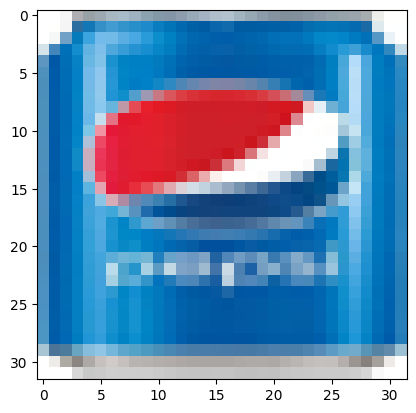

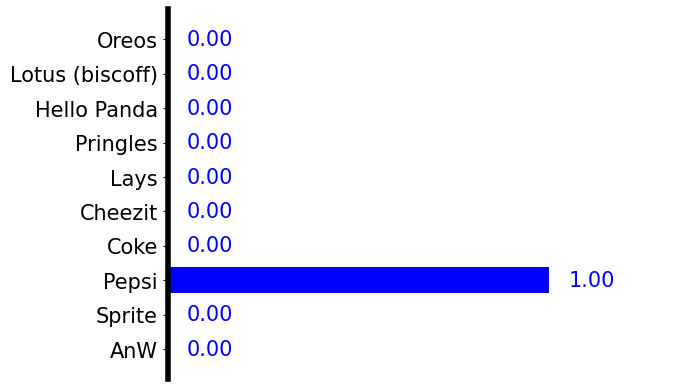

In [ ]:
# Choose a picture at random
idx = randint(0, num_test_data)
im = test_data[idx]

# diplay the picture
show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = (im - mean) / std
im = im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores = brand_Adam_CNN_net(im) 
probs = torch.softmax(scores, dim=1)
show_prob_brand(probs.cpu())

###Types classification

In [ ]:
type_Adam_CNN_net = CNN(3)

type_Adam_CNN_net = type_Adam_CNN_net.to(device)

mean = mean.to(device)

std = std.to(device)

In [ ]:
type_Adam_CNN_criterion = nn.CrossEntropyLoss()
type_Adam_CNN_lr = 0.001 
bs = 50

Similar to the brand classification CNN, we only ran the training loop for 10 epochs.

In [ ]:
start = time.time()

for epoch in range(15):
    
    # create a new optimizer at the beginning of each epoch; give the current learning rate.   
    type_Adam_CNN_optimizer = torch.optim.Adam(type_Adam_CNN_net.parameters() , lr=type_Adam_CNN_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_type_loss = 0
    running_type_error = 0
    num_batches = 0
    
    # set the order in which to visit the image from the training set
    shuffled_indices = torch.randperm(num_train_data)
 
    for count in range(0, num_train_data, bs):
    
        # Set the gradients to zeros
        type_Adam_CNN_optimizer.zero_grad()
        
        # Create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_type_labels = train_type_labels[indices] # difference between brand & type training
        
        # Send them to the gpu
        minibatch_data = minibatch_data.to(device)
        minibatch_type_labels = minibatch_type_labels.to(device)
        
        # Normalize the minibatch
        inputs = (minibatch_data - mean)/std
        
        # Tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # Forward the minibatch through the net 
        scores = type_Adam_CNN_net(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        type_loss = type_Adam_CNN_criterion(scores, minibatch_type_labels) 
        
        # Backward pass to compute dL/dU, dL/dV and dL/dW
        type_loss.backward()

        # Do one step of the optimizer
        type_Adam_CNN_optimizer.step()
        

        # START COMPUTING STATS
        
        # Add the loss of this batch to the running loss
        running_type_loss += type_loss.detach().item()
        
        # Compute the error made on this batch and add it to the running error       
        type_error = get_error(scores.detach(), minibatch_type_labels)
        running_type_error += type_error.item()

        num_batches += 1        
    
    
    # compute stats for the full training set
    total_type_loss = running_type_loss/num_batches
    total_type_error = running_type_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=', epoch, '\t total time=', elapsed, 'min', '\t lr=', type_Adam_CNN_lr, '\t loss=', total_type_loss, '\t error=', total_type_error*100, 'percent')

    eval_on_CNN_test_set(type_Adam_CNN_net, test_type_labels) 
    print(' ')

epoch= 0 	 total time= 0.03218006292978923 min 	 lr= 0.001 	 loss= 1.0389078054855119 	 error= 54.872305891407066 percent
test error= 40.081506967544556 percent
 
epoch= 1 	 total time= 0.06618280410766601 min 	 lr= 0.001 	 loss= 0.8740889376668788 	 error= 41.7844128252855 percent
test error= 39.85580123704055 percent
 
epoch= 2 	 total time= 0.10033934513727824 min 	 lr= 0.001 	 loss= 0.8128050423380154 	 error= 38.56716600816642 percent
test error= 44.238245487213135 percent
 
epoch= 3 	 total time= 0.13450677792231241 min 	 lr= 0.001 	 loss= 0.7689397548561665 	 error= 35.548923531574985 percent
test error= 32.97805806686138 percent
 
epoch= 4 	 total time= 0.1686069130897522 min 	 lr= 0.001 	 loss= 0.735741348408941 	 error= 34.67661827357848 percent
test error= 33.1536064887869 percent
 
epoch= 5 	 total time= 0.20278725226720173 min 	 lr= 0.001 	 loss= 0.6995527019251638 	 error= 31.353235511637443 percent
test error= 27.77429634127124 percent
 
epoch= 6 	 total time= 0.23693865

Testing on a random image from the test set.

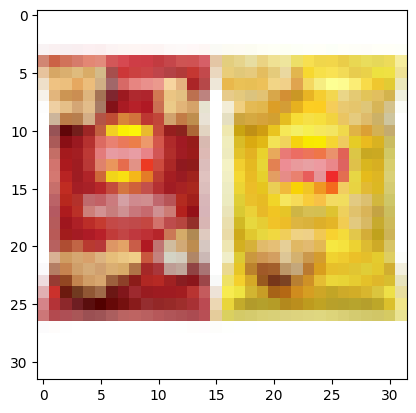

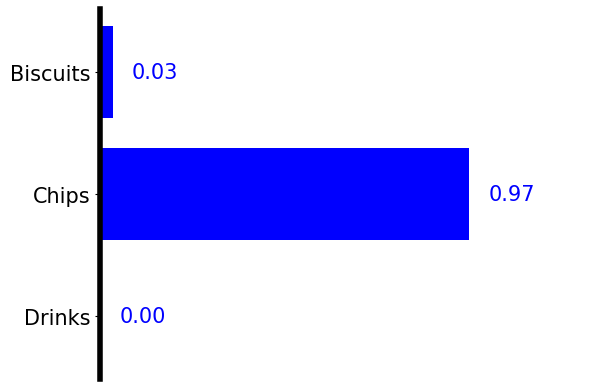

In [ ]:
# Choose a picture at random
idx = randint(0, num_test_data)
im = test_data[idx]

# diplay the picture
show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = (im - mean) / std
im = im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores = type_Adam_CNN_net(im) 
probs = torch.softmax(scores, dim=1)
show_prob_type(probs.cpu())

##Numerical Results Analysis for Adam Optimizers

The error rate graphs of the CNN models using Adam Algorithm Optimizers are shown below: 

<div>
<img src="https://drive.google.com/uc?id=1cNsrA2GT0_rK4V-4nntQ0gozZAe1lzij" width="500"/>
</div>

<div>
<img src="https://drive.google.com/uc?id=1PnCtdN1tFLgDeQEsqeZAYRbrzUqxKwfr" width="500"/>
</div>

As anticipated, the Adam optimmizer gave us a smoother learning curve, and drastically improved the time needed to properly train our neural networks, down to only 15 epochs from the original 50.

##Hyperparameters optimization for MLP

SGD optimiser was used for MLP. To understand the relationship between the hyperparameters (learning rate, batch size and number of epochs) and the total loss, test error and total error, different hyperparameter values were used in the 3-layer MLP. Batchsizes of 10, 50, 100, epoch values of 10, 50, 100 were used. A fixed learning rate of 0.01 and a learning rate of 0.25 that is halved every 5 epochs were used.
 
The relationship between the hyperparameters and accuracy is shown in the parallel coordinate plots below.
 
<div>
<img
src = "https://drive.google.com/uc?id=1BPug5p0D7ONl-fUr7p6r01UTqd9iB7Wl"
width = "800"/>
</div>
 
Using a fixed learning rate, it was observed that most of the time, using a large batch size and high number of epochs lead to higher accuracy, whereas using a small batch size and lower number of epochs lead to lower accuracy.
 
 
<div>
<img
src = "https://drive.google.com/uc?id=1i87dpz-UHTbhauJ50dSpLLjSUN0q39lu"
width = "800"/>
</div>
 
Using a decreasing learning rate, the same observations were made, but with a weaker correlation. This could be attributed to the higher learning rate of 2.5, which requires higher number epochs to decay until optimal.

##Feature Map Visualisation

To get a better understanding of how our CNN was working, the filters learnt with the CNN model were individually visualized for a random picture in every class for both brand and product type classification. The visualization of filters shows that our CNN model learns hierachical filters as the deeper the layer, the more details there are.

###Code

To pass an image from the testing data through the CNN filters, we would first have to extract the convolutional layers out as the ReLu, MaxPool2d and Linear layers are not neccesary for this visualization.

In [ ]:
model_weights =[]
conv_layers = []
model_children = list(net.children())

#number of conv layers
counter = 0

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

#display the conv layers and their weights
for layer in conv_layers:
    print(layer)

Then, the feature maps are generated to visualize the filters.

In [ ]:
outputs = []
names = []

for layer in conv_layers:
    print(f"Current layer is {layer}")
    print(im.size())
    im = layer(im)
    outputs.append(im)
    names.append(str(layer))

print(len(outputs))

#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

#converting from 3D tensors to 2D
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

Finally, the feature maps are printed.

In [ ]:
fig = plt.figure(figsize=(30, 50))

for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

###Brand

The pictures and corresponding filters of the classes in brands are shown below.

<header>
<h4><u>Oreos</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1eaW_xMPw0XGDNhvmXcwae4pIQDiMQyA8"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-EKutDUx6xdOqghMOgyXbSFu7EppW97a"
width = "500"/>
</div>

<header>
<h4><u>Lotus (Biscoff)</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1Ljr9uwK6dB-QfYTVoe-dHJv_coYe9CcY"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-I083o44QhI-cZMmm7n1s81uPDcZX9zr"
width = "500"/>
</div>

<header>
<h4><u>Hello Panda</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1a3iAQWyX8XSAUUzLV7ILXaXCO8Wd5uDs"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-10cN-j-Yf7rVUNVggRmZxhp4LjjOMlP"
width = "500"/>
</div>

<header>
<h4><u>Pringles</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=12ZPkEyP2RfxzM3C7FqHRP4XoLGNwhr7w"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1yy1SAXt0gDGAt7Q58M018EfzvcI5kvSX"
width = "500"/>
</div>

<header>
<h4><u>Lays</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1015zbfaXhrXH78DWnFPGSr65LLy0l1WW"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-0M_Zr3uSTi06GlI5nXbE2lA_a83q9wf"
width = "500"/>
</div>

<header>
<h4><u>Cheezit</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1hQtaw4f5qSMK7135RR5GfE6THoJkDIdP"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-Z818_P9SWb3QKbEySenad_D6P3wR1OX"
width = "500"/>
</div>

<header>
<h4><u>Coke</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1pvC1p1DN7f42hvUkaeTYLDeZfKLsWS3m"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-2wLy3xrtDNy3XdLfD7mytoSSsr_42Wf"
width = "500"/>
</div>

<header>
<h4><u>Pepsi</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1efp0F3htuUxJF0eh-7uOKztj8KF5YGF4"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1WBcAWpIdMuzCbzMWth-2xxXmCJNsm4wW"
width = "500"/>
</div>

<header>
<h4><u>Sprite</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1Hqo6agbyQ2QNz96BmEzLRYmd3yqVU9Gi"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-LU5ou3vKiZkpfZUeCGdWw5jO9vgOMRl"
width = "500"/>
</div>

<header>
<h4><u>AnW</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1puCvCj6Wd29PH4bZQ17tbpL_7kzYxR4M"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-2wLy3xrtDNy3XdLfD7mytoSSsr_42Wf"
width = "500"/>
</div>

###Product type

The pictures and corresponding filters of the classes of product types are shown below.

<header>
<h4><u>Biscuits</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1e92tEdcgY_vd3N2Xa_DruJeEdGlPDDlK"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1PxNP5Fo9IfAFdVUZaP0NtGXVx17RxlGA"
width = "500"/>
<div>

<header>
<h4><u>Chips</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1H735yu7KOjyYLSkvpOkOti54NB35kKYT"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1fqXaVzVXPGA6nf7FFrtEcQP9kwOw3244"
width = "500"/>
</div>

<header>
<h4><u>Drinks</u></h4>
</header>

<div>
<img
src = "https://drive.google.com/uc?id=1LF1_T0lfOAtvEfmtWMzAss1TO9wKMWGW"
width = "100"/>
<img
src = "https://drive.google.com/uc?id=1-0y009yzcSegftc7GrDSRyd03k9PJ53e"
width = "500"/>
</div>

#Final Conclusion

Our team has developed and trained two neural networks which are able to accurately classify products by their brand and product type respectively.

During this process, we found the CNN model to be more effective than the MLP model due to the CNN's greater flexibility when it comes to the position and orientation of the target object in the image.

Additionally, we foud that given a smaller, less consistent training set, using the Adam optimizer as opposed to the SGD optimizer can improve training efficiency dramatically.

The original goal for these neural networks was for them to be used in a sorting station to help workers quickly divide items by their brand or type.

Thus, should this project be further extended in the future, our team would suggest implementing object segmentation using algorithms such as R-CNN as discussed in Lecture 11. In doing so, the network would be able to sort multiple objects appearing in the same image, greatly increasing its efficiency.

#Individual Contributions



*   Nikita Goh Mei Xian:
    *   MLP architecture
    *   Hyperparameters optimization for MLP
    *   Feature map visualisation
*   Ye Jiaying:
    *   CNN architecture
    *   Numerical results analysis
*   Ethan Wong Goon Hong:
    *   Data collection & cleaning (web scraper)
    *   Adam optimizer implementation for CNN



# Appendix: utils.py

Modified `utils.py` file given to us for use during the CS4243 Labs.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs    


def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

def show_prob_type(p):
    p=p.data.squeeze().numpy()

    ft=15
    label = ('Biscuits', 'Chips', 'Drinks')
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)

    plt.show()


def show_prob_brand(p):
    p=p.data.squeeze().numpy()

    ft=15
    label = ('Oreos', 'Lotus (biscoff)', 'Hello Panda', 'Pringles', 'Lays', 'Cheezit', 'Coke', 'Pepsi', 'Sprite', 'AnW')
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)

    plt.show()